In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations (normalize + augmentation)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes


100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


In [2]:
class CustomCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [3]:
def train_model(model, trainloader, criterion, optimizer, epochs=10):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")

def evaluate_model(model, testloader):
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=classes))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


Epoch 1/10, Loss: 1.5646
Epoch 2/10, Loss: 1.2303
Epoch 3/10, Loss: 1.0801
Epoch 4/10, Loss: 0.9970
Epoch 5/10, Loss: 0.9428
Epoch 6/10, Loss: 0.9039
Epoch 7/10, Loss: 0.8693
Epoch 8/10, Loss: 0.8418
Epoch 9/10, Loss: 0.8193
Epoch 10/10, Loss: 0.7880
              precision    recall  f1-score   support

    airplane       0.74      0.81      0.77      1000
  automobile       0.89      0.86      0.87      1000
        bird       0.68      0.62      0.65      1000
         cat       0.66      0.51      0.57      1000
        deer       0.66      0.78      0.72      1000
         dog       0.64      0.71      0.67      1000
        frog       0.84      0.78      0.81      1000
       horse       0.73      0.84      0.78      1000
        ship       0.89      0.80      0.84      1000
       truck       0.86      0.82      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75  

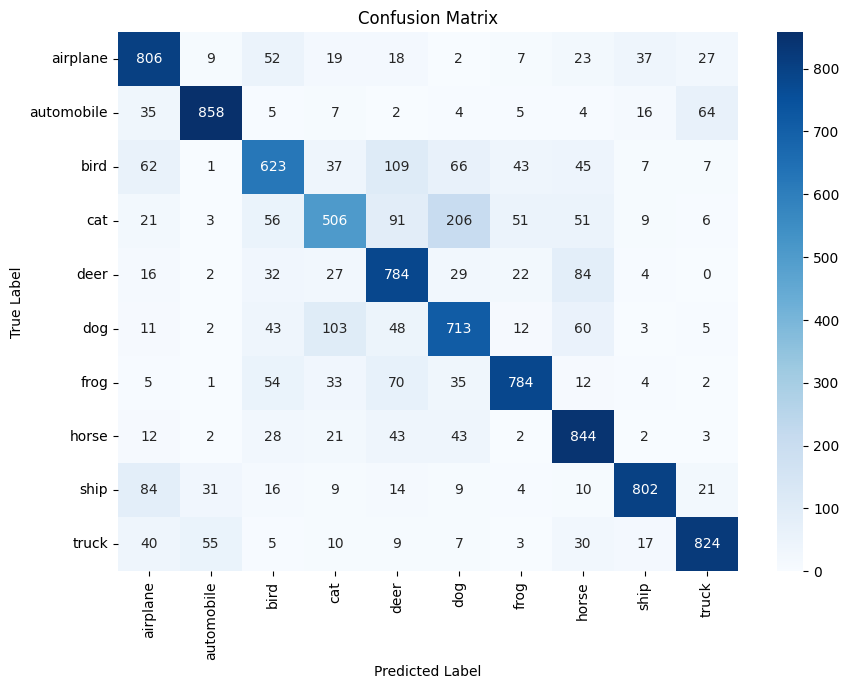

In [4]:
model = CustomCNN(dropout_rate=0.3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, trainloader, criterion, optimizer, epochs=10)
evaluate_model(model, testloader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


Epoch 1/5, Loss: 1.0204
Epoch 2/5, Loss: 0.7426
Epoch 3/5, Loss: 0.6517
Epoch 4/5, Loss: 0.5934
Epoch 5/5, Loss: 0.5588
              precision    recall  f1-score   support

    airplane       0.86      0.80      0.83      1000
  automobile       0.92      0.87      0.89      1000
        bird       0.76      0.79      0.78      1000
         cat       0.67      0.64      0.65      1000
        deer       0.81      0.83      0.82      1000
         dog       0.71      0.74      0.72      1000
        frog       0.89      0.84      0.86      1000
       horse       0.86      0.84      0.85      1000
        ship       0.82      0.91      0.86      1000
       truck       0.86      0.87      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



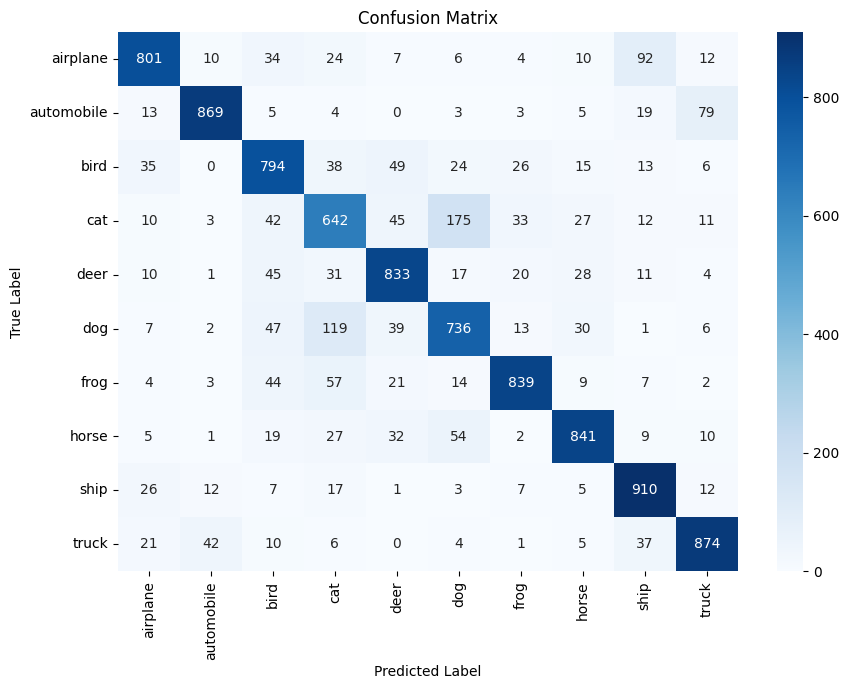

In [5]:
from torchvision.models import resnet18

# Load pretrained ResNet18
model_resnet = resnet18(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 10)  # Adapt final layer
model_resnet.to(device)

# Optimizer & loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0005)

# Train
train_model(model_resnet, trainloader, criterion, optimizer, epochs=5)
evaluate_model(model_resnet, testloader)



Training with dropout=0.3, lr=0.001
Epoch 1/5, Loss: 1.5767
Epoch 2/5, Loss: 1.2581
Epoch 3/5, Loss: 1.1199
Epoch 4/5, Loss: 1.0288
Epoch 5/5, Loss: 0.9761
              precision    recall  f1-score   support

    airplane       0.72      0.79      0.75      1000
  automobile       0.81      0.86      0.83      1000
        bird       0.73      0.47      0.57      1000
         cat       0.50      0.53      0.52      1000
        deer       0.70      0.59      0.64      1000
         dog       0.56      0.66      0.61      1000
        frog       0.75      0.79      0.77      1000
       horse       0.70      0.82      0.75      1000
        ship       0.86      0.80      0.83      1000
       truck       0.81      0.79      0.80      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



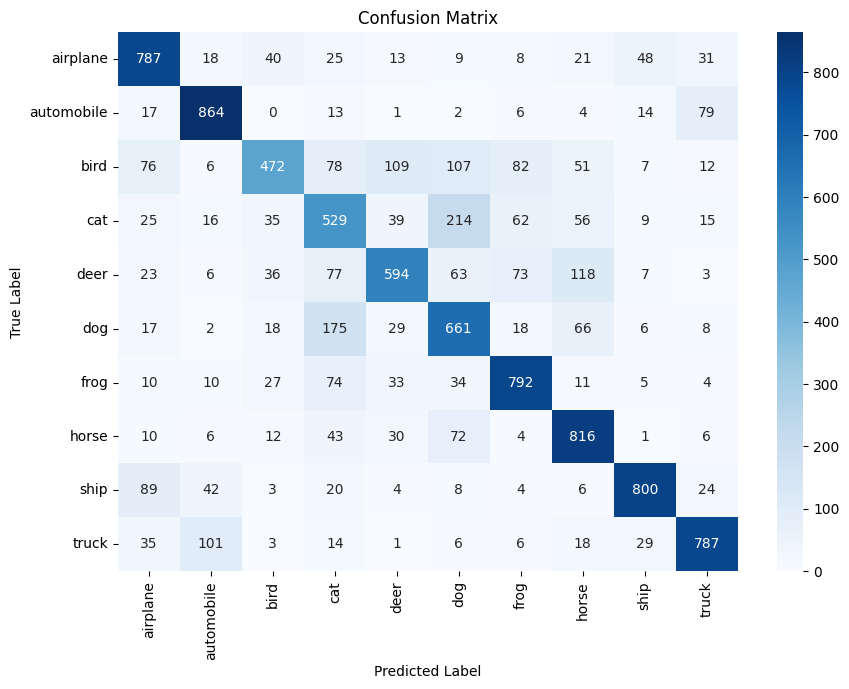


Training with dropout=0.3, lr=0.0005
Epoch 1/5, Loss: 1.6187
Epoch 2/5, Loss: 1.3288
Epoch 3/5, Loss: 1.1819
Epoch 4/5, Loss: 1.0874
Epoch 5/5, Loss: 1.0201
              precision    recall  f1-score   support

    airplane       0.66      0.81      0.73      1000
  automobile       0.80      0.80      0.80      1000
        bird       0.52      0.65      0.58      1000
         cat       0.60      0.33      0.42      1000
        deer       0.72      0.52      0.61      1000
         dog       0.58      0.62      0.60      1000
        frog       0.71      0.81      0.76      1000
       horse       0.69      0.79      0.74      1000
        ship       0.86      0.76      0.80      1000
       truck       0.75      0.80      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.68     10000
weighted avg       0.69      0.69      0.68     10000



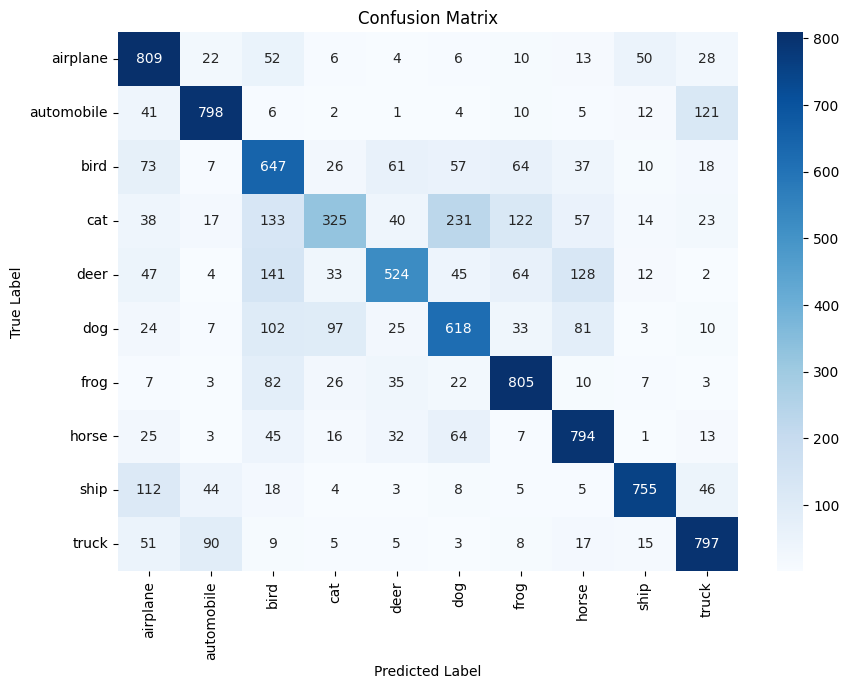


Training with dropout=0.5, lr=0.001
Epoch 1/5, Loss: 1.5896
Epoch 2/5, Loss: 1.2823
Epoch 3/5, Loss: 1.1522
Epoch 4/5, Loss: 1.0815
Epoch 5/5, Loss: 1.0235
              precision    recall  f1-score   support

    airplane       0.75      0.71      0.73      1000
  automobile       0.80      0.86      0.83      1000
        bird       0.64      0.53      0.58      1000
         cat       0.59      0.37      0.45      1000
        deer       0.69      0.62      0.65      1000
         dog       0.51      0.75      0.61      1000
        frog       0.77      0.79      0.78      1000
       horse       0.73      0.77      0.75      1000
        ship       0.73      0.89      0.81      1000
       truck       0.83      0.75      0.79      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



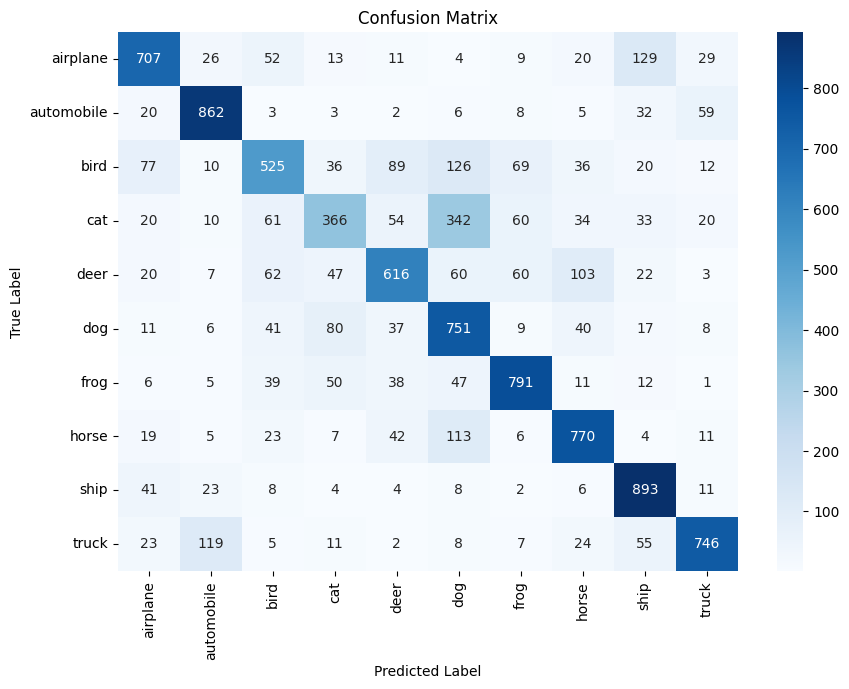


Training with dropout=0.5, lr=0.0005
Epoch 1/5, Loss: 1.6353
Epoch 2/5, Loss: 1.3539
Epoch 3/5, Loss: 1.2152
Epoch 4/5, Loss: 1.1250
Epoch 5/5, Loss: 1.0695
              precision    recall  f1-score   support

    airplane       0.71      0.71      0.71      1000
  automobile       0.77      0.83      0.80      1000
        bird       0.71      0.38      0.50      1000
         cat       0.49      0.52      0.51      1000
        deer       0.65      0.59      0.62      1000
         dog       0.54      0.66      0.59      1000
        frog       0.80      0.74      0.77      1000
       horse       0.63      0.81      0.71      1000
        ship       0.83      0.77      0.80      1000
       truck       0.73      0.78      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



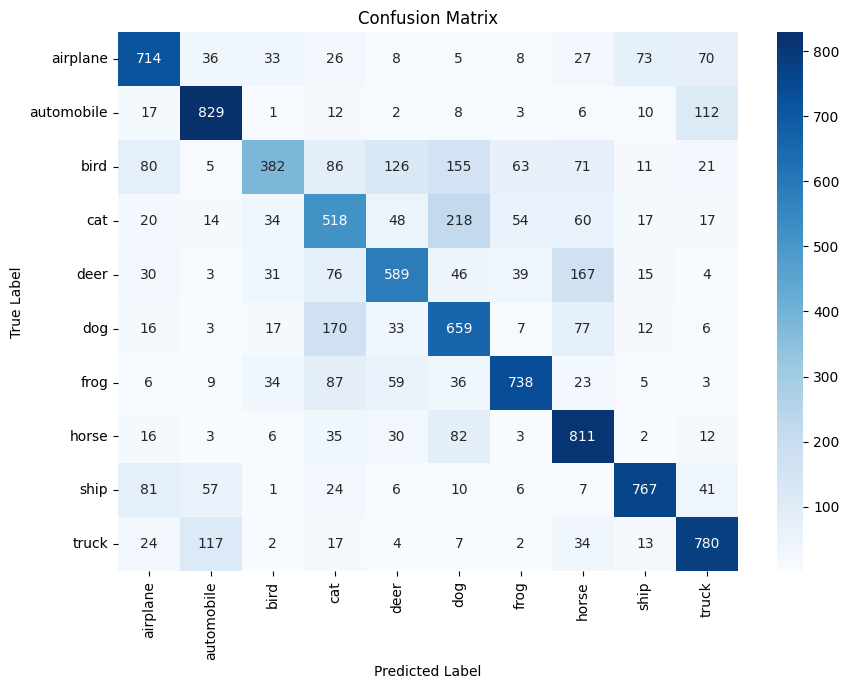

In [6]:
dropouts = [0.3, 0.5]
learning_rates = [0.001, 0.0005]

for d in dropouts:
    for lr in learning_rates:
        print(f"\nTraining with dropout={d}, lr={lr}")
        model = CustomCNN(dropout_rate=d)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_model(model, trainloader, criterion, optimizer, epochs=5)
        evaluate_model(model, testloader)
